# Model Coupling Master Logfile

## 2017-06-12

* Taking back up where we left off in September 2016

  - Created a new folder

        ~/SoC_Research/OceanAtmoshpereModelCoupling

      This folder combines the model coupling related material in

        ~/Git/gmcf (copied and cleaned up)

      and
        ~/201608_IOD_Saji (moved)

* In `gmcf`, TODO:
  - Make sure Gordon's changes are integrated but `#ifdef`-ed
  - Looks like I had been working to replace gmcfAPImodel1 by gmcfAPIocean and gmcfAPImodel2 by gmcfAPIatmosphere. But it is quite incomplete: the ocean model should send a temperature profile to the atmosphere as well. And of course we need to do all the proper interpolation
  
* Action plan
	1. Test the skeleton for coupling, ensure it does the right thing and debug (most likely)
	2. Replace the gmcfAPImodel* by the more realistic ocean and atmosphere APIs, test again
	3. Create the time and space interpolation and test
	4. Integrate into the gmcfAPI{ocean,atmoshpere} code
	5. Refactor and build the original ocean and atmosphere models.
	6. Replace the stub generators for temperature and wind profiles with the actual models
	7. Create realistic test runs
	

* Step 1:
	- Problem 1: Didn't build anymore.
	- Fix 1: add `quadmath` to `LIBS` in `SConstruct.OCEAN_ATMOSPHERE`
	
The code seems to work but it is currently a producer-consumer where model 2 does 10 time steps while model 1 does 200.
- Model 1 requests data from model 2 (var_name_1,var_name_1_prev,var_name_2,var_name_2_prev) before it acts on the data
	and does nothing afterwards
- Model 2 sends var_name_1 then modifies var_name_1 and var_name_2 then sends var_name_2 to model 1

For the ocean-atmosphere model we need to send data back from model 1 to model 2 after model 1 has computed. 
This means that I need a step, e.g.

	call gmcfPostModel1(v1sum,v2sum)
	
Furthermore, model 2 will need to receive these data, but obviously the first time there is nothing to receive.

## 2017-06-14

### Model configurations and interactions

#### Atmosphere model: 

        Delta t = 20 min
        
I call this the `GMCF_TIME_QUANTUM_MIN`

#### Ocean model: 

        Delta t = 480 min = 20*24 

#### Coupling 

Coupling period is 10 days (and at t=0 no coupling) = `10*24*60` min or `10*24*3` quanta
i.e. the atmosphere model takes 24 steps for 1 step of the ocean model
Totally ad-hoc, I set the offset to 1 quantum for uvw to ocean and 7 quanta for t to atmosphere

* Ocean is more fine-grained than Atmosphere
=> In ocean I must interpolate the Atmosphere values
=> In atmosphere I must sample the ocean values	
		        
#### Scenario

I will implement the following scenario:

- The atmosphere is much larger than the ocean (twice in every direction) but the resolution is say 5x less
- I will exchange the values between the models at different times. If we couple every 10 days, I assume we start with the atmosphere driving the ocean, and 8 days later the ocean drives the atmosphere.

This means that I need the ability to distinguish between such periodic events. 
In general, we can have k period events. They each have an offset from the start of the simulation and a period which is a multiple of the  time step of the slowest model.
For each of these k events we need to sync, and then take action for the appropriate event. 

For example, suppose the model time step is 20;  we have 3 exchange cycles: 40, 80 and 200 with an offset of resp. 20, 60 and 160
Reducing this it means

    (2,10);(4,6);(10,8)

the corresponding test is 

    (t-t_offset) >0 and (t-t_offset) % exchange_period ==0   
    
#### Generalisation to multiple models

The above is OK for 2 models. For multiple models, what we need is to check for each model if there is a sync point with a given other model. In other words, the tuple should also include the participants:

    (SYNC_PERIOD,SYNC_OFFSET, participating_models)
    
The data structure ofr `participating_models` is definitely related to the `gmcfConnectivityMatrix`, and assuming the number of models is never huge, we could do a linear search. 

For every model, all we need to know is when the sync points are, not actually what to do. So we can create a redundant list of gmcfSyncConfigurations, i.e. we make it a list of lists of tuples.

For every model, we go through one of the sublists by model index. From that we get the `current_sync_config`
    

In [413]:
dt = 20
gmcfSyncConfigurations = [(2,10),(4,6),(10,8)]

def gmcfCheckSync(sim_time,gmcfSyncConfigurations):
    current_sync_config=0;
    for (exchange_period,t_offset) in gmcfSyncConfigurations:
        current_sync_config+=1
        if sim_time >= t_offset and (sim_time-t_offset) % exchange_period == 0:
            print("\tSync for config ",current_sync_config,(exchange_period*dt,t_offset*dt))
            return current_sync_config       
        
for t in range(50):
    print("t :",t*dt)
    sync_case = gmcfCheckSync(t,gmcfSyncConfigurations)
    
    if sync_case == 1:
        print("Action ",sync_case)
    elif sync_case == 2:
        print("Action ",sync_case)
    elif sync_case == 3:
        print("Action ",sync_case)
        

t : 0
t : 20
t : 40
t : 60
t : 80
t : 100
t : 120
	Sync for config  2 (80, 120)
Action  2
t : 140
t : 160
	Sync for config  3 (200, 160)
Action  3
t : 180
t : 200
	Sync for config  1 (40, 200)
Action  1
t : 220
t : 240
	Sync for config  1 (40, 200)
Action  1
t : 260
t : 280
	Sync for config  1 (40, 200)
Action  1
t : 300
t : 320
	Sync for config  1 (40, 200)
Action  1
t : 340
t : 360
	Sync for config  1 (40, 200)
Action  1
t : 380
t : 400
	Sync for config  1 (40, 200)
Action  1
t : 420
t : 440
	Sync for config  1 (40, 200)
Action  1
t : 460
t : 480
	Sync for config  1 (40, 200)
Action  1
t : 500
t : 520
	Sync for config  1 (40, 200)
Action  1
t : 540
t : 560
	Sync for config  1 (40, 200)
Action  1
t : 580
t : 600
	Sync for config  1 (40, 200)
Action  1
t : 620
t : 640
	Sync for config  1 (40, 200)
Action  1
t : 660
t : 680
	Sync for config  1 (40, 200)
Action  1
t : 700
t : 720
	Sync for config  1 (40, 200)
Action  1
t : 740
t : 760
	Sync for config  1 (40, 200)
Action  1
t : 780
t : 8

Now, what we also need is the information about what to do at a given sync step. I think I'll do this via a case statement.



### Request or Push?

The main question to decide is if there is an advantage to the `request` approach.

I think the request approach is necessary when a model does not always need the same information. But because the whole current setup is compile-time decided, I think we can actually skip the requests and simply send the required data after syncing:

    call gmcfSync(sync_cases, sync_case)
    select (sync_case)
        case UVW_TO_OCEAN:
            call gmcfSend(...)
        case T_FROM_ATMOSPHERE:
            call gmcfWait(...)        
            call gmcfReceive(...)        
        

### Atmosphere model actions

1. The `atmosphere` model will send `wind_profile` to the `ocean` model using the `ATMOSPHERE_SYNC_PERIOD` and `ATMOSPHERE_SYNC_OFFSET`
2. The `atmosphere` model will receive `temp` from the `ocean` model using the `OCEAN_SYNC_PERIOD` and `OCEAN_SYNC_OFFSET`

The actions are then: 
- check for sync point
- sync
- send `wind_profile`
- wait for `temp`
- read `temp`


Currently we have following code:

        t_sync = t_atmosphere / t_sync_step ! means atmosphere steps are smaller and more frequent than ocean
        t_inter = mod(t_atmosphere,t_sync_step) ! for interpolation between two steps of atmosphere
        t_atmosphere = t_atmosphere + 1

This code assumes that there are two  models that exchange info with a fixed period. The new model defines a sync point purely in terms of the quantised time step of the model. 

I will assume that the time step of the original code for every model is simply 1, the start time 0. 
So inside the `gmcfSync` subroutine we multiply this with the appropriate time step and add any required offset.

Suppose the original code would not be so well-behaved then we need to do it a bit more complicated:

    delta_t = DELTA_T_SEC ! just to complicate matters
    do t = t_start, t_stop, t_step 
    ! the model will use this relative time `t` for its computations
    ! The absolute time is 
    t_in_min = t*delta_t/60
    t_norm = (t_in_min / GMCF_TIME_QUANTUM) 

For example if `t_start=3` and `t_step=4` then `t = 3,7,11,15,...`
What we want is the number of quanta elapsed since the start of the simulation.
So first we substract the offset `t_start`: `t-t_start = 0,4,8,12,...`
Then we divide by `t_step`: `t_start`: `(t-t_start)/t_step = 0,1,2,3,...`
Let's call this the `n_ticks`:

    n_ticks = (t-t_start)/t_step


Now we need to relate this to the quanta, and we know that the `GMCF_TIME_QUANTUM` is the GCD. The interval in minutes between two ticks is `t_step*delta_t/60` so to get the number of quanta, we have

    quanta_per_tick = ( t_step*delta_t/60 ) / GMCF_TIME_QUANTUM
    
This is `GMCF_TIME_STEP_ATMOSPHERE`, so the input for `gmcfSync` is the `n_ticks`.

Sanity check: for the ocean model, `Delta_t` = 20 minutes or 20*60 seconds; `t_step=1; t_start=0`

So we have:

    n_ticks = t
    GMCF_TIME_STEP_OCEAN = quanta_per_tick = ( 1*20*60/60 ) / 20 = 1


So `n_ticks` is the value that goes into the `gmcfSync` call. In the call we need the number of quanta elapsed since the start of the simulation, this should be `n_ticks * GMCF_TIME_STEP_ATMOSPHERE + GMCF_TIME_OFFSET_ATMOSPHERE`:

    sim_time = n_ticks * GMCF_TIME_STEP_ATMOSPHERE + GMCF_TIME_OFFSET_ATMOSPHERE
    
We then compare `sim_time` to the possible sync configurations for the model.

The call to `gmcfSync` is blocking. I think we should do nothing else in the `gmcfSyncAtmosphere` call.
Instead, the `gmcfSyncAtmosphere` should return the `current_sync_config` and the `gmcfPreAtmosphere` call should use this to decide if it has to send or receive.

We can make `current_sync_config` and `is_sync_point` module globals, so that we don't have to pass them explicitly between the calls.


### Need for Pre/Post?

The order of events is:
- sync if required
- if sync, exchange data (PRE)
- compute
- if sync, exchange data (POST)

Arguably, we should receive in PRE and send in POST, because that means we compute using newly received values and send newly computed values. 

However, if I do that with two models, then in the PRE stage both models wait for data, so there will be deadlock! To avoid that I should let each model send the data right away, in PRE.
Clearly, both models will then also receive in PRE. After computation they could in principle send the data too, and then that data would be pending in the queue until a sync, and then there would be no need for a send in PRE. But that is unsafe ans serves no particular purpose. So I guess POST has no use for the case of mutual exchange. If the models are actually dependent, i.e. not running concurrently, then POST is useful.

### Note about organisation of the configurations

At the moment I use parameters such as `GMCF_TIME_STEP_<model>`. This is unpractical. A better way is to create a record type for all the configuration data, and then create an array of records for all models. That will make the overall code much more generic. But what to put in a configuration is not so easy to determine.



### Domain interpolation

I want the atmosphere domain to be twice as large as the ocean domain but with `1/5` of the resolution
So if the ocean is `100 x 100`, the atmosphere will be `200/5 x 200/5`



Now suppose I want the ocean to cover from `30/5` to `130/5` and from `40/5` to `140/5`

    integer, parameter :: ATMOSPHERE_IP=48,ATMOSPHERE_JP=48,ATMOSPHERE_KP=27
            
The ratio is encoded in 

    integer, parameter :: ATMOSPHERE_DI=5,ATMOSPHERE_DJ=5,ATMOSPHERE_DK=1
            
I'm not happy with these names. The correct approach would be to define OCEAN_OFFSET_FROM_ATMOSPHERE_X, OCEAN_OFFSET_FROM_ATMOSPHERE_Y 

    integer, parameter :: ATMOSPHERE_IMS=6,ATMOSPHERE_JMS=8,ATMOSPHERE_KMS=1
    integer, parameter :: ATMOSPHERE_IME=26,ATMOSPHERE_JME=28,ATMOSPHERE_KME=27


### Time interpolation

- Time interpolation actually only works in proper producer-consumer cases
- In a case with mutual exchange of data, interpolation is impossible without introducing an artificial phase shift, so the action of one model will lag on the action of another. With more than two models this would I think quickly result in incorrect simulations.
- The alternative, extrapolation, leads to potential overshoot on maxima and undershoot on minima, as well as introduction of higher-order frequencies in the signal.
- So piecewise constant is the best possible alternative? Maybe not. What we can do is interpolate between the old and the new value, leaving the new value as the last one in the interval.
This requires us to know how many ticks there are between updates. 





### Ocean model actions

1. The `ocean` model will send `temp` to the `atmosphere` model using the `OCEAN_SYNC_PERIOD` and `OCEAN_SYNC_OFFSET`
2. The `ocean` model will receive `wind_profile` from the `atmosphere` model using the `ATMOSPHERE_SYNC_PERIOD` and `ATMOSPHERE_SYNC_OFFSET`

The actions are then: 
- check for sync point
- sync
- send `temp`
- wait for `wind_profile`
- read `wind_profile`

## 2017-06-15

Space interpolation: fortunately we can take this straight from Numerical Recipes and I already wrote most of the code. 
Main change this involves is that I need to provide auxiliary arrays with the latitudinal and longitudinal coordinates, or for the simple case at least the offset and grid size. 


## 2017-06-16

I thought about a test scenario and realised that basically there are two possibilities: 

- Concurrent: the two models sync, exchange data, work, repeat;
- Dependent: the two models sync, model1 sends to model2, model2 works, model2 sends to model1, model1 works, repeat

The concurrent case is I think most representative for e.g. ocean-atmosphere interactions as clearly they both "run" in parallel.


In [414]:
# Concurrent case: 

def f1(v1,v2):
    return v1+v2/2.0

def f2(v1,v2):
    return v1-2*v2
    
v1=2
v2=2
for t in range(0,10):
    v1r = v1
    v2r = v2
    v1 = f1(v1r, v2r)
    v2 = f2(v2r, v1r)    
    print(v1,v2)
    
    

3.0 -2
2.0 -8.0
-2.0 -12.0
-8.0 -8.0
-12.0 8.0
-8.0 32.0
8.0 48.0
32.0 32.0
48.0 -32.0
32.0 -128.0


In [415]:
# Dependent case : Fibonacci

def f1(v):
    return v[0]+v[1]

def f2(v1,v2):
    return [v1[1],v2]
    
v1=0
v2=[1,1]
for t in range(0,10):
    v2r = v2
    v1 = f1(v2r)
    v1r = v1    
    v2 = f2(v2, v1r)    
    print(v2)

[1, 2]
[2, 3]
[3, 5]
[5, 8]
[8, 13]
[13, 21]
[21, 34]
[34, 55]
[55, 89]
[89, 144]


The main task to do to finish step 1 of my action plan is to create the `lat` and `lon` coordinate arrays.

## 2017-06-19

### In terms of the action plan, I think I have now do steps 1, 2 and 3. So now I need to test the system in its current state.

* Test functionality without any interpolation: use the test example above. But what I think I'll do is read the v1 and v2 from the temperature and wind profile arrays. Also, I will make the u,v,w and temp arrays the same size in both models.

!!! FIXME: the `.tdc64` file *must* currently be named `gmfc.tdc64` because it is hardcoded in `gmcfCoupler.cc`

But apart from that, after some fumbling with Fortran print formats

        print 7188, model_id, v1,t_surface(1,1),u(1,1,1)
        7188 format("FORTRAN MODEL ",i1, " v1 = ",f8.1,' = (',f8.1,' + ',f8.1,' / 2 )')
                 
This produces the same output as the example above:

        [ocean-atmosphere-model-coupling]$ ./gmcfCoupler | grep 'v1'
        FORTRAN MODEL 1 v1 =      3.0 = (     2.0 +      2.0 / 2 )
        FORTRAN MODEL 1 v1 =      2.0 = (     3.0 +     -2.0 / 2 )
        FORTRAN MODEL 1 v1 =     -2.0 = (     2.0 +     -8.0 / 2 )
        FORTRAN MODEL 1 v1 =     -8.0 = (    -2.0 +    -12.0 / 2 )
        FORTRAN MODEL 1 v1 =    -12.0 = (    -8.0 +     -8.0 / 2 )
        FORTRAN MODEL 1 v1 =     -8.0 = (   -12.0 +      8.0 / 2 )
        FORTRAN MODEL 1 v1 =      8.0 = (    -8.0 +     32.0 / 2 )
        FORTRAN MODEL 1 v1 =     32.0 = (     8.0 +     48.0 / 2 )
        FORTRAN MODEL 1 v1 =     48.0 = (    32.0 +     32.0 / 2 )
        FORTRAN MODEL 1 v1 =     32.0 = (    48.0 +    -32.0 / 2 )
        FORTRAN MODEL 1 v1 =    -32.0 = (    32.0 +   -128.0 / 2 )


## 2017-06-20

* The next step I think is to use different domain sizes but simply pick a subdomain with the size of the smallest domain for transfers. We can test this by using values from the lower-left and upper-right corners and compute the same function for both of them.

I want this subdomain to be static, and it would be part of the scenario eventually. So I guess we just need a subroutine that takes the original domain array, the target subdomain array and the corner index 4-tuple,

```fortran
    subroutine gmcfExtract2DSubdomain(subd_indices, domain, subdomain)
        integer, dimension(4), intent(In) :: subd_indices
        real(kind=4), dimension(:,:) , intent(In) :: domain
        real(kind=4), dimension(:,:) , intent(InOut) :: subdomain
        subdomain = domain(subd_indices(1):subd_indices(2),subd_indices(3):subd_indices(4))
    end subroutine gmcfExtract2DSubdomain
```    

As the ocean model sends a subdomain to the atmosphere model, we need another subroutine to insert this subdomain into the domain as well:
```fortran    
    subroutine gmcfInsert2DSubdomain(subd_indices, domain, subdomain)
        integer, dimension(4), intent(In) :: subd_indices
        real(kind=4), dimension(:,:) , intent(InOut) :: domain
        real(kind=4), dimension(:,:) , intent(In) :: subdomain
        domain(subd_indices(1):subd_indices(2),subd_indices(3):subd_indices(4))=subdomain
    end subroutine gmcfInsert2DSubdomain
```    

Next step: different time steps, e.g. the ones from original models.

    

In [416]:
# Concurrent case with different time steps and a long sync period

quantum = 20 # minutes
sync_period = 1*24*3 # quanta

ocean_sync_period = sync_period # quanta
ocean_timestep = 1 # quantum
ocean_offset = 0 
atmosphere_timestep = 24 # quanta
atmosphere_offset = 0
atmosphere_sync_period = sync_period

def ocean(v1,v2):
    return v1+v2/200.0

def atmosphere(v1,v2):
    return v1-2*v2
    
v1=2
v1b=2
v2=2
v2b=2
n_ticks_ocean=0
n_ticks_atmosphere=0
for t in range(0,770):

    sim_time_ocean=n_ticks_ocean*ocean_timestep+ocean_offset
    sim_time_atmosphere=n_ticks_atmosphere*atmosphere_timestep+atmosphere_offset
#     print(t,sim_time_ocean,sim_time_atmosphere,sim_time_ocean% sync_period==0,sim_time_atmosphere % sync_period==0,sync_period)
# ocean and atmosphere sync 
    if (sim_time_ocean% sync_period==0 and sim_time_atmosphere % sync_period==0):
#         print(t,v1,v2)
#         print('FORTRAN MODEL 1 v1b = %8.1f + %8.1f /200.0' % (v1,v2))
        v1r = v1
        v2r = v2
        
# ocean computes for every t 
    if (t % ocean_timestep == 0):
        n_ticks_ocean+=1
        v1b = ocean(v1, v2r)
        if (t%72==0):
            print('\tFORTRAN MODEL 1 v1b =\t%8.1f = ( %8.1f + %8.1f / 200 )'.expandtabs(4) % (v1b,v1,v2))
        v1=v1b
        
# atmosphere computes 
    if t % atmosphere_timestep == 0:
        n_ticks_atmosphere+=1         
        v2 = atmosphere(v2, v1r)    

    

    FORTRAN MODEL 1 v1b =        2.0 = (      2.0 +      2.0 / 200 )
    FORTRAN MODEL 1 v1b =        2.7 = (      2.7 +    -10.0 / 200 )
    FORTRAN MODEL 1 v1b =       -1.0 = (     -0.9 +    -26.3 / 200 )
    FORTRAN MODEL 1 v1b =      -10.5 = (    -10.4 +    -21.0 / 200 )
    FORTRAN MODEL 1 v1b =      -17.7 = (    -17.9 +     41.1 / 200 )
    FORTRAN MODEL 1 v1b =       -2.4 = (     -3.1 +    148.7 / 200 )
    FORTRAN MODEL 1 v1b =       51.2 = (     50.4 +    167.5 / 200 )
    FORTRAN MODEL 1 v1b =      110.0 = (    110.7 +   -134.8 / 200 )
    FORTRAN MODEL 1 v1b =       58.2 = (     62.1 +   -798.9 / 200 )
    FORTRAN MODEL 1 v1b =     -231.3 = (   -225.5 +  -1171.8 / 200 )
    FORTRAN MODEL 1 v1b =     -646.4 = (   -647.3 +    181.0 / 200 )


The Fortran coupled model yields:

    [ocean-atmosphere-model-coupling]$ ./gmcfCoupler | grep v1b
    FORTRAN MODEL 1 v1b =      2.0 = (     2.0 +      2.0 / 200 )
    FORTRAN MODEL 1 v1b =      2.7 = (     2.7 +    -10.0 / 200 )
    FORTRAN MODEL 1 v1b =     -1.0 = (    -0.9 +    -26.3 / 200 )
    FORTRAN MODEL 1 v1b =    -10.5 = (   -10.4 +    -21.0 / 200 )
    FORTRAN MODEL 1 v1b =    -17.7 = (   -17.9 +     41.1 / 200 )
    FORTRAN MODEL 1 v1b =     -2.4 = (    -3.1 +    148.7 / 200 )
    FORTRAN MODEL 1 v1b =     51.2 = (    50.4 +    167.5 / 200 )
    FORTRAN MODEL 1 v1b =    110.0 = (   110.7 +   -134.8 / 200 )
    FORTRAN MODEL 1 v1b =     58.2 = (    62.1 +   -798.9 / 200 )
    FORTRAN MODEL 1 v1b =   -231.3 = (  -225.5 +  -1171.8 / 200 )
    FORTRAN MODEL 1 v1b =   -646.4 = (  -647.3 +    181.0 / 200 )
    
So all is well. We can now move on to time and space interpolation. First, space interpolation. 



## 2017-06-21 

## Spatial interpolation revisited
- The subdomain must be larger in terms of coordinate box than the target domain, i.e. the coordinates corresponding to the corners of the subdomain but in the atmosphere domain must create a box that is larger than the coordinate box for the complete ocean domain.
- A consequence of interpolation is that the temperature values going from the ocean to the atmosphere will be computed  only for the inner points of the subdomain, not the boundary. We can either copy the points or extrapolate.

### Spatial interpolation on constant-spaced grids

If the lat and lon coordinates for both grids have a constant spacing, interpolation becomes simpler because we do not have to find the starting index for the interpolation by search through the coordinates. Instead, we can simply calculate it.
I use `_t` for _target_, `_o` for _original_, `_g` for _given_ `_c` for _calculated_.
```fortran
    subroutine calc_idx_ratio(x_g,x_0,d_x,i_c,a_c)
        integer, intent(InOut) :: i_c
        real(kind=4), intent(InOut) :: a_c
        real(kind=4), intent(In) :: x_g, x_0, d_x
        real(kind=4) :: i_a
        i_a = (x_g-x_o)/d_x
        i_c = int( i_a )
        a_c = i_a - real(i_c)
    end subroutine calc_idx_ratio
```

Now, `x_g` is defined by the offset and spacing of the grid:

Then with these values for lat and lon, we can easily do bilinear interpolation on an array v. 

    x_g = (i_t - i_b_t)*d_x_t+x_0_t
    y_g = (j_t - j_b_t)*d_y_t+y_0_t
    (i_c,ax_c) = calc_idx_ratio_coord(x_g,x_0_o,d_x_o)    
    (j_c,ay_c) = calc_idx_ratio_coord(y_g,y_0_o,d_y_o)
    

In [417]:
# For simplicity I will assume that the indices start at 0
def calc_coord(idx,d_x,x_0):
    x_g = idx*d_x+x_0
    return x_g

In [418]:
import math
def calc_idx_ratio_coord(x_g,d_x,x_0):
#     print('<X',x_g,'-',x_0,'/',d_x,'>', end='')
    i_a = (x_g-x_0)/(1.0*d_x)
    i_c = math.floor( i_a )
    a_c = i_a - i_c
#     print('<I',i_a,';',i_c,',',a_c,'>', end='')    
    return (i_c,a_c) 

# For convenience we can combine both functions

def calc_idx_ratio(i_t,d_x_t,x_0_t,d_x_o,x_0_o):
    x_g = calc_coord(i_t,d_x_t,x_0_t)
#     print('<G',x_g,'>', end='')
    (i_c,a_c) = calc_idx_ratio_coord(x_g,d_x_o,x_0_o)
    return (i_c,a_c) 


The four points enclosing (x_g,y_g) are given by

    v(i_c,j_c)
    v(i_c+1,j_c)
    v(i_c,j_c+1)
    v(i_c+1,j_c+1)
    
Calculating the target value for v is now very simple: the weight of each corner point is proportional to the area between the target point and the opposite corner:

In [419]:
def bilin_interpol_point(v,i_c,ax_c,j_c,ay_c):
#     print(v[i_c][j_c],ax_c,ay_c,v[i_c+1][j_c],(1-ax_c),ay_c,v[i_c][j_c+1],ax_c,(1-ay_c) ,v[i_c+1][j_c+1],(1-ax_c),(1-ay_c))
#     print(v[i_c][j_c],v[i_c+1][j_c],v[i_c][j_c+1],v[i_c+1][j_c+1],end=' ')
    v_t = \
        v[i_c][j_c]*(1-ax_c)*(1-ay_c) + \
        v[i_c+1][j_c]*(ax_c)*(1-ay_c) + \
        v[i_c][j_c+1]*(1-ax_c)*(ay_c) + \
        v[i_c+1][j_c+1]*(ax_c)*(ay_c)
    return v_t                          

So let's test this with following example:

In [420]:
# Original grid (this would be the subdomain from the atmosphere)

n_x_o = 5
n_y_o = 5

x_0_o = 20
d_x_o = 15

y_0_o = 20
d_y_o = 15

for i_o in range(0,n_x_o):
    for j_o in range(0,n_y_o):
        x_g = calc_coord(i_o,d_x_o,x_0_o)
        y_g = calc_coord(j_o,d_y_o,y_0_o)
        print("(%d,%d)" % (x_g,y_g),end="\t")
    print('')

(20,20)	(20,35)	(20,50)	(20,65)	(20,80)	
(35,20)	(35,35)	(35,50)	(35,65)	(35,80)	
(50,20)	(50,35)	(50,50)	(50,65)	(50,80)	
(65,20)	(65,35)	(65,50)	(65,65)	(65,80)	
(80,20)	(80,35)	(80,50)	(80,65)	(80,80)	


In [421]:
# Target grid

n_x_t = 7
n_y_t = 7

x_0_t = 26
d_x_t = 8
y_0_t = 26
d_y_t = 8

for i_t in range(0,n_x_t):
    for j_t in range(0,n_y_t):
        x_g = calc_coord(i_t,d_x_t,x_0_t)
        y_g = calc_coord(j_t,d_y_t,y_0_t)
        print("(%d,%d):(%d,%d)" % (i_t,j_t,x_g,y_g),end="\t")
    print('')    

(0,0):(26,26)	(0,1):(26,34)	(0,2):(26,42)	(0,3):(26,50)	(0,4):(26,58)	(0,5):(26,66)	(0,6):(26,74)	
(1,0):(34,26)	(1,1):(34,34)	(1,2):(34,42)	(1,3):(34,50)	(1,4):(34,58)	(1,5):(34,66)	(1,6):(34,74)	
(2,0):(42,26)	(2,1):(42,34)	(2,2):(42,42)	(2,3):(42,50)	(2,4):(42,58)	(2,5):(42,66)	(2,6):(42,74)	
(3,0):(50,26)	(3,1):(50,34)	(3,2):(50,42)	(3,3):(50,50)	(3,4):(50,58)	(3,5):(50,66)	(3,6):(50,74)	
(4,0):(58,26)	(4,1):(58,34)	(4,2):(58,42)	(4,3):(58,50)	(4,4):(58,58)	(4,5):(58,66)	(4,6):(58,74)	
(5,0):(66,26)	(5,1):(66,34)	(5,2):(66,42)	(5,3):(66,50)	(5,4):(66,58)	(5,5):(66,66)	(5,6):(66,74)	
(6,0):(74,26)	(6,1):(74,34)	(6,2):(74,42)	(6,3):(74,50)	(6,4):(74,58)	(6,5):(74,66)	(6,6):(74,74)	


In [422]:
# Values on the original grid

v_o=[]
for i_o in range(0,n_x_o):
    row=[]
    for j_o in range(0,n_y_o):        
        row+=[i_o+2*j_o+1]
    v_o+=[row]
for i_o in range(0,n_x_o):
    for j_o in range(0,n_y_o):
        print("%d" % (v_o[i_o][j_o]),end="\t")
    print('')        

1	3	5	7	9	
2	4	6	8	10	
3	5	7	9	11	
4	6	8	10	12	
5	7	9	11	13	


In [423]:
# Now let's interpolate v_o for all points in the target grid and wrap it in a nice function
# We keep the original values if a point is out of range

def bilinear_interpolation(v_o,grid_o,v_t_in,grid_t):    
    (n_x_o,d_x_o,x_0_o,n_y_o,d_y_o,y_0_o)=grid_o
    (n_x_t,d_x_t,x_0_t,n_y_t,d_y_t,y_0_t)=grid_t    
    v_t=v_t_in
    for i_t in range(0,n_x_t):
        for j_t in range(0,n_y_t):
            (i_c,ax_c) = calc_idx_ratio(i_t,d_x_t,x_0_t,d_x_o,x_0_o)
            (j_c,ay_c) = calc_idx_ratio(j_t,d_y_t,y_0_t,d_y_o,y_0_o)
            if (i_c>=0 and i_c<n_x_t and j_c>=0 and j_c<n_y_t):                
                v_t[i_t][j_t] = bilin_interpol_point(v_o,i_c,ax_c,j_c,ay_c)
#             else:
#                 print("Index out of range: (",i_c,',',j_c,')')                                
#                 v_t[i_t][j_t] = 0.0 # for testing               
    return v_t

v_t=[]
for i_t in range(0,n_x_t):
    row=[]
    for j_t in range(0,n_y_t):        
        row+=[0.0]
    v_t+=[row]

# Test it:
grid_o = (n_x_o,d_x_o,x_0_o,n_y_o,d_y_o,y_0_o)
grid_t = (n_x_t,d_x_t,x_0_t,n_y_t,d_y_t,y_0_t)    

v_t = bilinear_interpolation(v_o,grid_o,v_t,grid_t)   

for i_t in range(0,n_x_t):
    for j_t in range(0,n_y_t):
        print("%3.2f" %(v_t[i_t][j_t]),end=" ")
    print('') 


2.20 3.27 4.33 5.40 6.47 7.53 8.60 
2.73 3.80 4.87 5.93 7.00 8.07 9.13 
3.27 4.33 5.40 6.47 7.53 8.60 9.67 
3.80 4.87 5.93 7.00 8.07 9.13 10.20 
4.33 5.40 6.47 7.53 8.60 9.67 10.73 
4.87 5.93 7.00 8.07 9.13 10.20 11.27 
5.40 6.47 7.53 8.60 9.67 10.73 11.80 


#### Now the reverse operation

Interpolation only works if the target grid fits inside the original grid. So the reverse operation can only be done one a subgrid of the original grid. Because we keep the original values for points that can't be interpolated be get the original array back.


In [424]:
v_oi = bilinear_interpolation(v_t,grid_t,v_o,grid_o)    

for i_o in range(0,n_x_o):
    for j_o in range(0,n_y_o):
        print("%3.2f" %(v_oi[i_o][j_o]),end=" ")
    print('') 

1.00 3.00 5.00 7.00 9.00 
2.00 4.00 6.00 8.00 10.00 
3.00 5.00 7.00 9.00 11.00 
4.00 6.00 8.00 10.00 12.00 
5.00 7.00 9.00 11.00 13.00 


In [425]:
v_o=[]
for i_o in range(0,n_x_o):
    row=[]
    for j_o in range(0,n_y_o):        
        row+=[0.0]
    v_o+=[row]
v_t=[]
for i_t in range(0,n_x_t):
    row=[]
    for j_t in range(0,n_y_t):        
        row+=[2.0]
    v_t+=[row]

v_oi = bilinear_interpolation(v_t,grid_t,v_o,grid_o)    

for i_o in range(0,n_x_o):
    for j_o in range(0,n_y_o):
        print("%3.2f" %(v_oi[i_o][j_o]),end=" ")
    print('') 

    

0.00 0.00 0.00 0.00 0.00 
0.00 2.00 2.00 2.00 0.00 
0.00 2.00 2.00 2.00 0.00 
0.00 2.00 2.00 2.00 0.00 
0.00 0.00 0.00 0.00 0.00 


Interesting point: in Fortran the result was not the same because I originally had

```fortran
        int( i_a )
```       
as equivalent of Python's
```python
        math.floor( i_a )
```        
However, the correct version is
```fortran
        int( floor(i_a) )
```        
because 

        int(x), -1.0 < x < 0.0 == 0
        
whereas 

        floor(x), -1.0 < x < 0.0 == -1.0
        
        

### Spatial interpolation on non-constant-spaced grids

For this we use the code based on the Numerical Recipes book. However, this seems optimised for sequential execution

#### Computational cost and parallelisation

If the spacing is irregular, we need to find the indices in the original array between which the given coord point is to be interpolated. The naive way is to iterate through the indices, calculated the original coordinate, compare, and stop when the orig coord is larger than the given coord. The index is the one before that.
Caching the found index is a good optimisation for a sequential algorithm. Assuming the grid sizes are $n_t$ and $n_o$, then the naive approach requires $O(n_t.n_o)$, whereas the cached version only $O(n_t)$.

If we want to parallelise the operation, we can't use this approach. I think the best case is a bisection search as this will cost $O(n_t.log_2(n_o))$ and given sufficient parallelism it can be $O(log_2(n_o))$. Note that the constant space version of course would be $O(1)$.


## Spatial interpolation test

As a start we test with the same conditions as above, the idea is that we receive the fields, interpolate , interpolate in reverse and send them back, and there should be no change.

First of all, I set all sizes to the test above, OK.

Now I try interpolation, `test_interpolation.f95` to make sure the F95 code works like the Python code, OK.

    [Models]$./test_interpolation
     Orig
      1.00  3.00  5.00  7.00  9.00
      2.00  4.00  6.00  8.00 10.00
      3.00  5.00  7.00  9.00 11.00
      4.00  6.00  8.00 10.00 12.00
      5.00  7.00  9.00 11.00 13.00
     Interpolation
      2.20  3.27  4.33  5.40  6.47  7.53  8.60
      2.73  3.80  4.87  5.93  7.00  8.07  9.13
      3.27  4.33  5.40  6.47  7.53  8.60  9.67
      3.80  4.87  5.93  7.00  8.07  9.13 10.20
      4.33  5.40  6.47  7.53  8.60  9.67 10.73
      4.87  5.93  7.00  8.07  9.13 10.20 11.27
      5.40  6.47  7.53  8.60  9.67 10.73 11.80
     Reconstruction
      1.00  3.00  5.00  7.00  9.00
      2.00  4.00  6.00  8.00 10.00
      3.00  5.00  7.00  9.00 11.00
      4.00  6.00  8.00 10.00 12.00
      5.00  7.00  9.00 11.00 13.00

So now we are ready to try temporal interpolation.

## Time interpolation

To test time interpolation I think the signals in both models must be much smoother than in the contrived example above.

Let's assume we have a sine wave in each model, and the exchange causes a perturbation:

$$
f_1(t)=a_1.sin(\omega_1.t+\phi_1)+\epsilon_1.f_2(t)\\
f_2(t)=a_2.sin(\omega_2.t+\phi_2)+\epsilon_2.f_1(t)
$$

In these equations, $\epsilon_1$ and $\epsilon_2$ are small and  $\omega_1$ and $\omega_2$ are not multiples of one another.

We keep the time constants etc as in the previous example. 

In [25]:
# Concurrent case with different time steps and a long sync period

from math import sin,pi

quantum = 20 # minutes
sync_period = 1*24*3 # quanta

ocean_sync_period = sync_period # quanta
ocean_timestep = 1 # quantum
ocean_offset = 0 
atmosphere_timestep = 24 # quanta
atmosphere_offset = 0
atmosphere_sync_period = sync_period

def ocean(t,v2):
    a1=16
    omega1=pi/360
    phi1=pi/4
    eps1=5e-1
    return a1*sin(omega1*t+phi1)+eps1*v2

def atmosphere(t,v1):
    a2=12
    omega2=pi/240
    phi2=3*pi/4
    eps2=5e-1
    return a2*sin(omega2*t+phi2)+eps2*v1
    
v1=1
v1b=1
v2=1
v2b=1
n_ticks_ocean=0
n_ticks_atmosphere=0
s1l=[]
s2l=[]
tl=[]

for t in range(0,1200):

    sim_time_ocean=n_ticks_ocean*ocean_timestep+ocean_offset
    sim_time_atmosphere=n_ticks_atmosphere*atmosphere_timestep+atmosphere_offset
# ocean and atmosphere sync 
    if (sim_time_ocean% sync_period==0 and sim_time_atmosphere % sync_period==0):
#         print(t,v1,v2)


        v1r = v1
        v2r = v2
        
# ocean computes for every t (ocean_timestep==1)
    if (t % ocean_timestep == 0):
        n_ticks_ocean+=1
        v1b = ocean(t,v2r)
#         if (t%72==0):
#             print('%d\t%8.3f\t%8.3f'.expandtabs(4) % (t,v1,v2))
        v1=v1b
        
# atmosphere computes every n timesteps (atmosphere_timestep==24)
    if t % atmosphere_timestep == 0:
        n_ticks_atmosphere+=1         
        v2 = atmosphere(t,v1r)  
        
# Create arrays for plotting
    s1l+=[ v1 ]
    s2l+=[ v2r ]
    tl+=[ t ]        

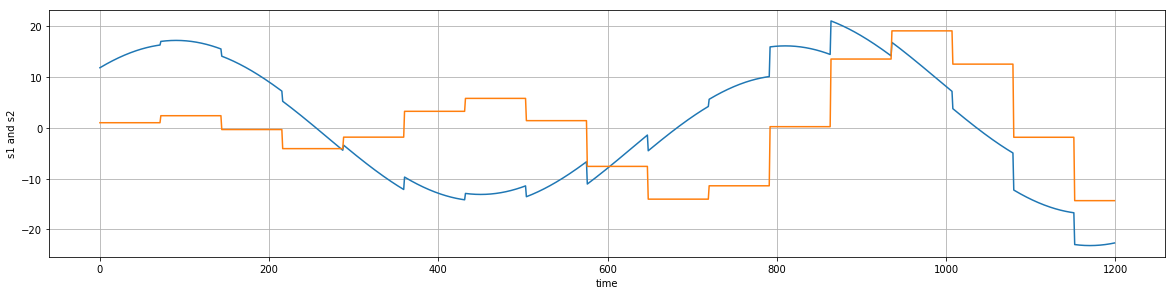

In [26]:
import numpy as np
import matplotlib.pyplot as plt

s1=np.array(s1l)
s2=np.array(s2l)
t=np.array(tl)

plt.subplots(figsize=(20, 10))
plt.subplot(211)
plt.plot(t, s1, t, s2)

plt.xlabel('time')
plt.ylabel('s1 and s2')
plt.grid(True)

plt.show()

## 2017-06-22

### Unrelated: colorising output from the build system

To make it easier to parse the output of the GMCF build system I wanted to colorise it. The script is below; you run it like this:

        ./build_gmcf_OCEAN_ATMOSPHERE  2>&1 | ./colorise.pl -

I used `tput setaf $code` to get the colour codes.

In [30]:
%%perl
use strict;
no strict qw( refs vars );
use warnings;
no warnings 'once';

# Only valid for codes up to 15! Works on Linux and Mac
my @colors=qw( 
    black 
    red 
    green 
    yellow 
    blue 
    magenta 
    cyan 
    lightgrey 
    grey 
    brightred 
    brightgreen 
    brightyellow 
    brightblue 
    brightmagenta 
    brightcyan 
    white 
);

my $i=0;
map {$$_ = calc_code($i++)} @colors;

while (<>) {
    chomp;
    if( /error/i ) {
        print "$brightred$_$white\n";
    } elsif ( /warning/i ) {
        print "$red$_$white\n";
    } elsif ( /\#/ ) {
        print "$green$_$white\n";
    } elsif ( /scons:/ ) {
        print "$grey$_$white\n";
    } elsif ( /^[A-Z]/ ) {
        print "$yellow$_$white\n";
    } else { print "$_\n";
    }
}

sub calc_code {(my $i)=@_;
    my @codes =  (27, 91 ,51+int($i / 8)*6,48+($i % 8), 109 );
    my $code_str = join('', map { chr($_) } @codes );
    return $code_str;
}

    ./gmcfCoupler | grep 'OCEAN:' > time_interpol_ocean.log

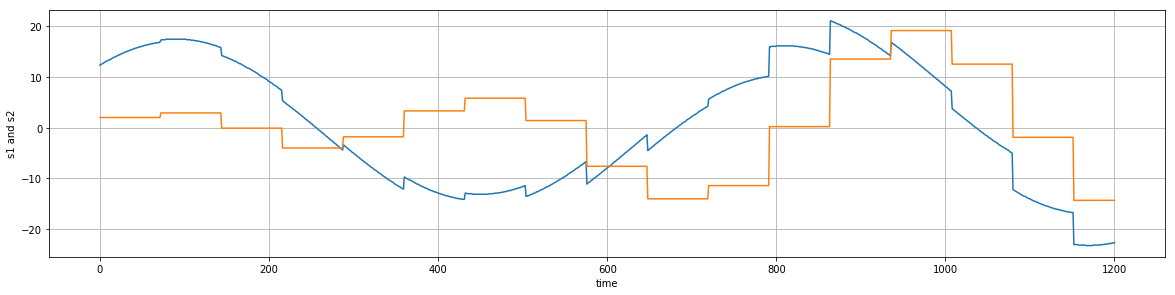

In [23]:
import numpy as np
import matplotlib.pyplot as plt
data = np.genfromtxt('./time_interpol_ocean.log',  names=['n','t', 'v1', 'v2'])
s1=data['v1'] #np.array(s1l)
s2=data['v2'] #np.array(s2l)
t=data['t'] #np.array(tl)

plt.subplots(figsize=(20, 10))
plt.subplot(211)
plt.plot(t, s1, t, s2)

plt.xlabel('time')
plt.ylabel('s1 and s2')
plt.grid(True)

plt.show()


The above is the situation at the ocean model. At the athmosphere model we get:

    ./gmcfCoupler | grep 'ATMOSPHERE:' > time_interpol_atmosphere.log 

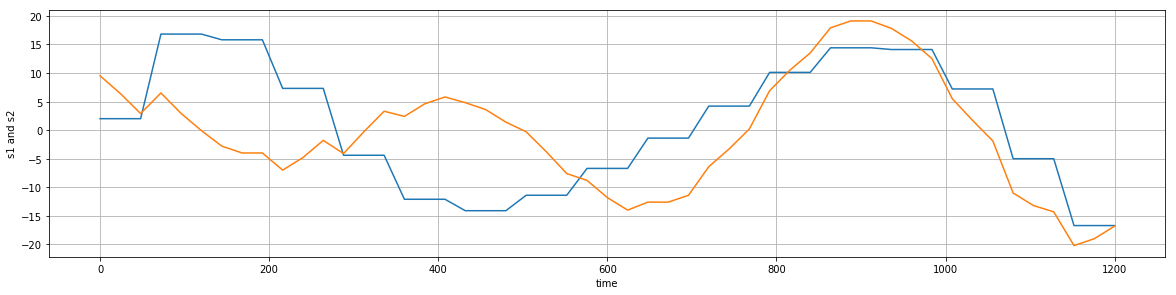

In [24]:

import numpy as np
import matplotlib.pyplot as plt
data = np.genfromtxt('./time_interpol_atmosphere.log',  names=['n','t', 'v1', 'v2'])
s1=data['v1'] #np.array(s1l)
s2=data['v2'] #np.array(s2l)
t=data['t'] #np.array(tl)

plt.subplots(figsize=(20, 10))
plt.subplot(211)
plt.plot(t, s1, t, s2)

plt.xlabel('time')
plt.ylabel('s1 and s2')
plt.grid(True)

plt.show()

## 2017-06-23 

Strictly speaking what we do is not interpolation as we use the current and previous value. The main purpose is to smooth out the steps in the curve. I tried a few different approaches, but I think linear interpolation has the best effect.

### Linear time interpolation

```fortran
    v_act =  ((v - v_prev)/(delta_t - 1) )*t + v_prev
```    

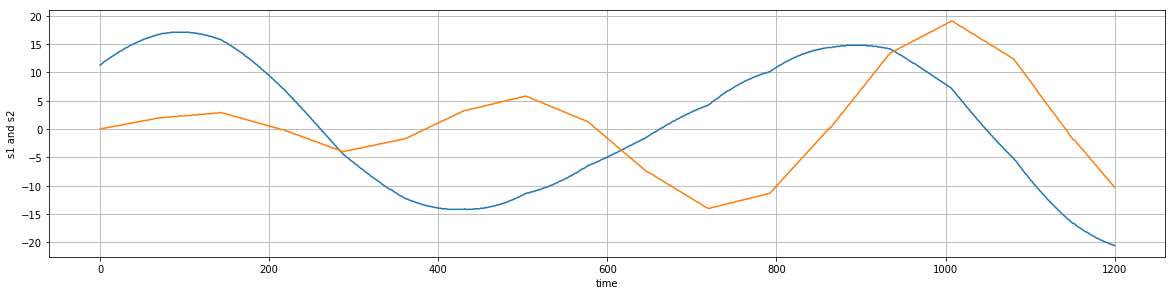

In [7]:
#define GMCF_INTERPOL_TIME
#define INTERPOL_SCHEME 1
#./gmcfCoupler | grep 'OCEAN:' > time_interpol_ocean_linear.log
import numpy as np
import matplotlib.pyplot as plt
data = np.genfromtxt('./time_interpol_ocean_linear.log',  names=['n','t', 'v1', 'v2'])
s1=data['v1'] #np.array(s1l)
s2=data['v2'] #np.array(s2l)
t=data['t'] #np.array(tl)

plt.subplots(figsize=(20, 10))
plt.subplot(211)
plt.plot(t, s1, t, s2)

plt.xlabel('time')
plt.ylabel('s1 and s2')
plt.grid(True)

plt.show()

### Exponentially damped time interpolation

Alternative to linear:

    v_act =  v + (v_prev-v)*exp(-n_taus*t_r/delta_t)
    
The parameter `n_taus` is by default set to 8. 

Below is a comparison between linear and exponential.

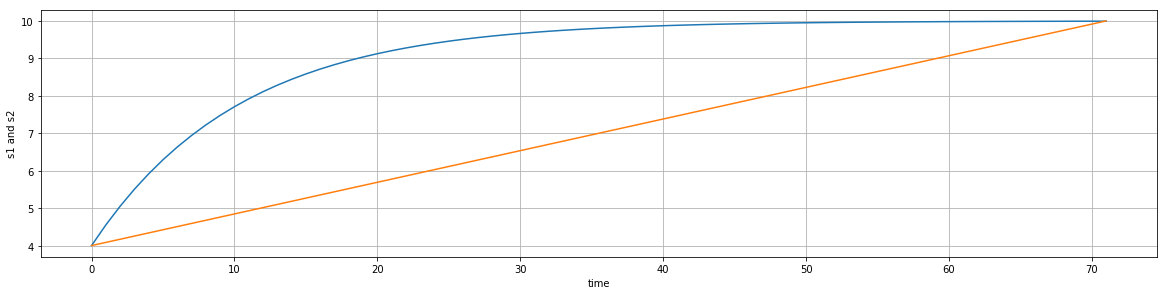

In [4]:
delta_t=72
v_prev = 4
v = 10
n_taus=10
tl=[]
v_act_l=[]
v1_l=[]
v2_l=[]
for t in range(0,delta_t):
    tl+=[t]
    v_act = v + (v_prev-v)*(2**(-n_taus*t/delta_t)) # v1 + v2
    v2 =  ((v - v_prev)/(delta_t - 1) )*t + v_prev
    v_act_l+=[v_act]
    v2_l+=[v2]
    
    
import numpy as np
import matplotlib.pyplot as plt

s1=np.array(v1_l)
s2=np.array(v2_l)
s3=np.array(v_act_l)
t=np.array(tl)

plt.subplots(figsize=(20, 10))
plt.subplot(211)
plt.plot(t,s3,t,s2)

plt.xlabel('time')
plt.ylabel('s1 and s2')
plt.grid(True)

plt.show()    

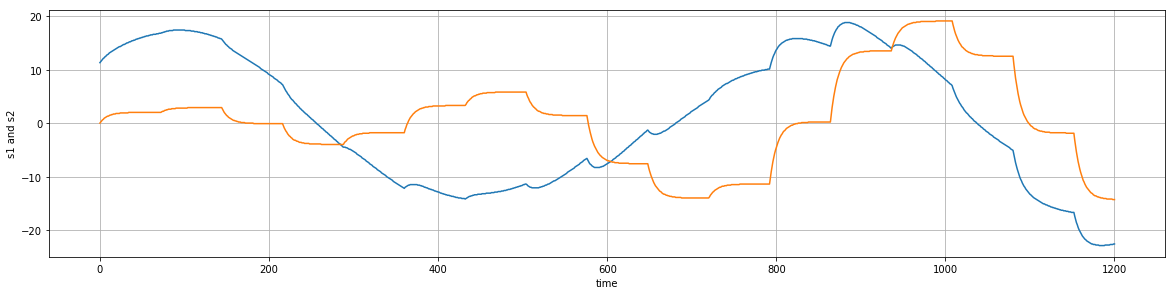

In [6]:
#define GMCF_INTERPOL_TIME
#define INTERPOL_SCHEME 2
#./gmcfCoupler | grep 'OCEAN:' > time_interpol_ocean_exp.log
import numpy as np
import matplotlib.pyplot as plt
data = np.genfromtxt('./time_interpol_ocean_exp.log',  names=['n','t', 'v1e', 'v2e'])
s1=data['v1e'] #np.array(s1l)
s2=data['v2e'] #np.array(s2l)
t=data['t'] #np.array(tl)

plt.subplots(figsize=(20, 10))
plt.subplot(211)
plt.plot(t, s1, t, s2)

plt.xlabel('time')
plt.ylabel('s1 and s2')
plt.grid(True)

plt.show()

### Stepwise constant interpolation

For the first half of the interval we use `(v_prev+v)/2`, for the rest we use `v`.

```fortran
    if (t<delta_t/2) then
        v_act = (v_prev+v)/2
    else
        v_act = v
    end if
```


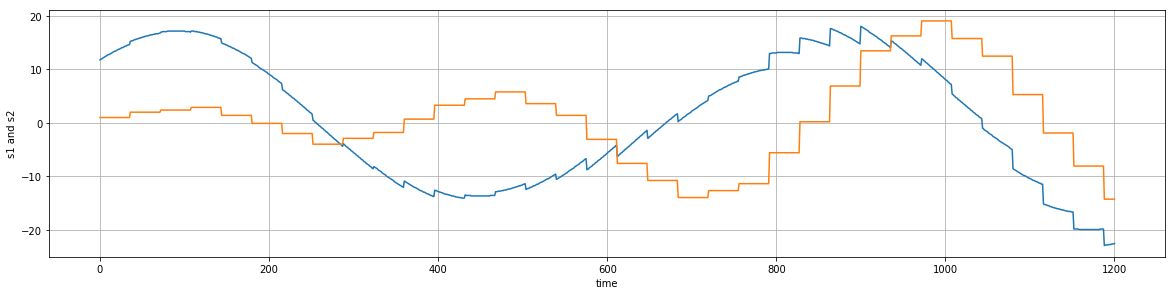

In [36]:
#define GMCF_INTERPOL_TIME
#define INTERPOL_SCHEME 3
#./gmcfCoupler | grep 'OCEAN:' > time_interpol_ocean_hyb.log
import numpy as np
import matplotlib.pyplot as plt
data = np.genfromtxt('./time_interpol_ocean_hyb.log',  names=['n','t', 'v1', 'v2'])
s1=data['v1'] #np.array(s1l)
s2=data['v2'] #np.array(s2l)
t=data['t'] #np.array(tl)

plt.subplots(figsize=(20, 10))
plt.subplot(211)
plt.plot(t, s1, t, s2)

plt.xlabel('time')
plt.ylabel('s1 and s2')
plt.grid(True)

plt.show()

### 2016-06-26

### Spatial rotation

In some cases the source and destination domains can be rotated relative to each other. In such a case we need to rotate the domain before interpolating it:


$$
x_r = x.cos\,\alpha - y.sin\,\alpha \\
y_r = x.sin\,\alpha + y.cos\,\alpha
$$

Then we use the  $x_r$ and $y_r$ values just like before. Of course this requires that the rotated domain still fits in the original domain.

For example, suppose the ocean domain is rotates wrt the atmosphere domain, then the rotation will determine the size and position of the subdomain. The rotated domain gets a new bounding box (defined by `W,H,X0,Y0`) by applying the above formula:

```fortran
    W_R = NX*DX*cos(ALPHA)+NY*DY*sin(ALPHA)
    H_R = NY*DY*cos(ALPHA)+NX*DX*SIN(ALPHA)
    if (ALPHA > 0) then
        X0_R = IB-NY*DY*sin(ALPHA)
        Y0_R = Y0
    else
        X0_R = X0
        Y0_R = Y0+NX*DX*sin(ALPHA)
    endif
```

The subdomain should encompass this new bounding box.  We interpolate the values for the rotated coordinates on the subdomain.

### Refactoring and testing the Ocean model

The ocean model is [GModel](http://www.sciamachy-validation.org/research/CKO/gmodel.html), the source code resides under:

        [Gmodel]$ pwd
        ./201608_IOD_Saji/ocean/Gmodel
        
and has following structure:
    
        [Gmodel]$ ls -1
        Coupled/
        Forced/
        Fsu/
        Makefile
        Model/
        Statatm/
        Wind/

First, we run the `cpp` macro processor on the code in `Model` using the script `run_cpp.pl`:

In [ ]:
%%perl
#!/usr/bin/env perl
use v5.22;
use warnings;
use strict;

use Cwd;
my $wd=cwd();

my $VV=0;

# SYS_Linux SYS_UNIX CODE_ASCII CODE_IEEE CODE_ENDIAN
my @macros=qw( );

my @srcdirs=qw(.);

my @includes = map {"-I$wd/".$_}  @srcdirs;
my $includestr = join(' ',@includes);

my @includes_l1 = map {"-I$wd/../".$_}  @srcdirs;
my $includestr_l1 = join(' ',@includes);

my @defines = map {"-D".$_}  @macros;
my $definestr = join(' ',@defines);

if (not -d "$wd/../PostCPP") {
    mkdir "$wd/../PostCPP";
}

my @srcs = glob("*.F");
for my $src (@srcs) {
    my $srcf =$src;
    $srcf=~s/F$/f/;
    say("cpp -P  $includestr $definestr -Wno-extra-tokens $src > $wd/../PostCPP/$srcf") if $VV;
    system("cpp -P  $includestr $definestr -Wno-extra-tokens $src > $wd/../PostCPP/$srcf");
}

for my $srcdir (@srcdirs) {
    if (not -d "$wd/../PostCPP/$srcdir") {
        system("mkdir -p $wd/../PostCPP/$srcdir");
    }
    chdir "$wd/$srcdir";
    my @srcs = glob("*.F");
    for my $src (@srcs) {
        my $srcf =$src;
        $srcf=~s/F$/f/;
        say("cpp -P  $includestr_l1 $definestr -Wno-extra-tokens $src > $wd/../PostCPP/$srcdir/$srcf") if $VV;
        system("cpp -P  $includestr_l1 $definestr -Wno-extra-tokens $src > $wd/../PostCPP/$srcdir/$srcf");
    }
    chdir $wd;
}


The preprocessed code is generated in `./PostCPP`. Then we refactor this code using [our refactoring source to source compiler](https://github.com/wimvanderbauwhede/RefactorF4Acc). The setup file `rf4a.cfg` is:

        [PostCPP]$ cat rf4a.cfg 
        TOP = bahr
        PREFIX = .
        SRCDIRS = .
        NEWSRCPATH = ../RefactoredSources
        #EXCL_SRCS = 
        #EXCL_DIRS = 
        #NO_MODULE =  
        NO_ONLY = 1
        SPLIT_LONG_LINES = 0
        RENAME_EXT = _G

And we run the compiler using 

        $HOME/Git/RefactorF4Acc/refactorF4acc.pl -c ./rf4a.cfg -g
        
As usual after work on the compiler this led to some errors, the main reason was that the parser for the read and write statements does not produce an AST so we currently ignore such lines. That combined with the fact that the latest changes made RefactoredArgs obsolete.

To test, we build using the following `SConstruct`:

In [13]:
import os
FC=os.environ.get('FC')

fsources = [
'addabc.f95','addcon.f95','averag.f95','bahr.f95','params_commons.f95','contoc.f95','diagnos.f95','fluxoc.f95',
'gridos.f95','hovout.f95','intfsum.f95','iocean.f95','maxims.f95','multip.f95','ninout.f95','ofield.f95',
'parames.f95','patch.f95','rangau.f95','restax.f95','select.f95','setval.f95','shallow.f95','slvout.f95',
'ssteqs.f95','sstout.f95','starts.f95','stoatm.f95','stress.f95','yemoda.f95']

LDFLAGS= []
FFLAGS_F95  = ['-Ofast', '-m64', '-Wall','-Wno-unused','-Wno-unused-dummy-argument','-ffree-form', '-ffree-line-length-none'] 

envF95=Environment(F95=FC,LINK=FC,LINKFLAGS=LDFLAGS,F95FLAGS=FFLAGS_F95,F95PATH=['.','..'])
envF95.Program('GModel',fsources,LIBS=[],LIBPATH=['.'])


NameError: name 'Environment' is not defined

Then we go to `./Forced`, and use the script `forced_refactored_new.sc` to generate a log file `forced_refactored_new.log`
The run creates several files but we use `sstano.dat` which is contains the SST anomaly (deviation from normal) over time. 

I validated by comparing the output of this file with the previous one, but I also created a movie to visualise this output, using `gnuplot` to create `png` heatmap images and `ffmpeg` to glue them together. 

In [18]:
%%perl DO_NOT_RUN
#!/usr/bin/perl
use warnings;
use strict;

# Split the output into separate files
open my $IN, '<', 'sstano.dat';
my $OUT;
while(my $line = <$IN>) {
    $line=~/#\s+(\d+)/ && do {
        open $OUT, '>','sstano_'.$1.'.dat';
   };
       print $OUT $line;
  } 
close $OUT;
close $IN;

# Create a gnuplot script to generate a png for every file
# The output is per month between 1966 and 1999
my $k=0;
for my $i (66 .. 99) {
for my $j (1 ..12) {
    $k++;
my $jj= $j<10 ? "0$j": "$j";

my $kkk= $k< 10? '00'.$k: $k<100 ? '0'.$k : $k;
    open my $GP, '>', 'gen_sstano_heatmap.gnuplot';

    print $GP <<"ENDGP";
set term png            
set output "sstano_$kkk.png"
set cbrange [-3:3]
plot 'sstano_19$i$jj.dat' matrix with image

ENDGP

    close $GP;
    system("gnuplot gen_sstano_heatmap.gnuplot");
}
}

# Generate the movie
system('rm *.mp4');
system('ffmpeg -framerate 6 -i sstano_%03d.png -vf format=yuv420p sstano_heatmap.mp4');
# Clean up
system('rm *.png');
system('rm sstano_*.dat');


Can't open perl script "DO_NOT_RUN": No such file or directory


And this is the resulting video, for the orginal and the refactored code:   

In [15]:
%%HTML
<video width="480" height="360" controls autoplay>
  <source src="./201608_IOD_Saji/ocean/Gmodel/Forced/sstano_heatmap_orig.mp4" type="video/mp4">      
</video><video width="480" height="360" controls autoplay>
    <source src="./201608_IOD_Saji/ocean/Gmodel/Forced/sstano_heatmap_ref.mp4" type="video/mp4">
</video>

### Refactoring and testing the Atmosphere model

The atmosphere model is [](http://), the source code resides under:

        [model]$ pwd
        ./201608_IOD_Saji/atmosphere/ln_solver/model/
        
and has following structure:
    
        [model]$ ls -1
        bin/
        doc/
        lib/
        sh/
        src/
        
The actual sources are in `src`, which has following structure:        


    [src]$ find . -type d
    ./admin
    ./dynamics
    ./include
    ./io
    ./physics
    ./proj
    ./proj/aim
    ./proj/baro
    ./proj/dcore
    ./proj/hs
    ./proj/mkamat
    ./proj/tintgr
    ./proj/wvfrc.topo
    ./sysdep
    ./util
    ./util/pack
    
First, we run the `cpp` macro processor on the code in `src` using the script `run_cpp.pl`, very similar to the above one. 

In [17]:
%%perl DO_NOT_RUN
#!/usr/bin/env perl
use v5.22;
use warnings;
use strict;

use Cwd;
my $wd=cwd();

my $VV=0;

# SYS_Linux SYS_UNIX CODE_ASCII CODE_IEEE CODE_ENDIAN
my @macros=qw( OPT_NOPHYSICS OPT_NOUSER OPT_CLASSIC);

my @srcdirs=qw(admin
dynamics
include
io
physics
proj/tintgr
sysdep
util);

my @includes = map {"-I$wd/".$_}  @srcdirs;
my $includestr = join(' ',@includes);

my @includes_l1 = map {"-I$wd/../".$_}  @srcdirs;
my $includestr_l1 = join(' ',@includes);

my @defines = map {"-D".$_}  @macros;
my $definestr = join(' ',@defines);

if (not -d "$wd/../PostCPP") {
    mkdir "$wd/../PostCPP";
}


my @srcs = glob("*.F");
for my $src (@srcs) {
    my $srcf =$src;
    $srcf=~s/F$/f/;
    say("cpp -P  $includestr $definestr -Wno-extra-tokens $src > $wd/../PostCPP/$srcf") if $VV;
    system("cpp -P  $includestr $definestr -Wno-extra-tokens $src > $wd/../PostCPP/$srcf");
}

for my $srcdir (@srcdirs) {
    if (not -d "$wd/../PostCPP/$srcdir") {
        system("mkdir -p $wd/../PostCPP/$srcdir");
    }
    chdir "$wd/$srcdir";
    my @srcs = glob("*.F");
    for my $src (@srcs) {
        my $srcf =$src;
        $srcf=~s/F$/f/;
        say("cpp -P  $includestr_l1 $definestr -Wno-extra-tokens $src > $wd/../PostCPP/$srcdir/$srcf") if $VV;
        system("cpp -P  $includestr_l1 $definestr -Wno-extra-tokens $src > $wd/../PostCPP/$srcdir/$srcf");
    }
    chdir $wd;
}


Can't open perl script "DO": No such file or directory


The preprocessed code is generated in `./PostCPP`. Then we refactor this code using [our refactoring source to source compiler](https://github.com/wimvanderbauwhede/RefactorF4Acc). The setup file `rf4a.cfg` is:

        [PostCPP]$ cat rf4a.cfg 
        TOP = agcm
        PREFIX = .
        SRCDIRS = ., dynamics, physics, proj/tintgr, sysdep, util
        NEWSRCPATH = ../RefactoredSources
        EXCL_SRCS = util/usubs.f, util/ucaln.f, ./zeq1main.f, ./cplmain.f, dynamics/dhydr.f, admin/aadmn.f, admin/astrt.f, admin/auser.f
        EXCL_DIRS = io, include, sysdep
        NO_MODULE =  ./util/uspst.f, ./admin/astup.f, ./admin/atime.f, ./admin/asetc.f, ./admin/asets.f, ./admin/apcon.f
        NO_ONLY = 1
        SPLIT_LONG_LINES = 0
        
And we run the compiler using 

        $HOME/Git/RefactorF4Acc/refactorF4acc.pl -c ./rf4a.cfg -g
        
As usual after work on the compiler this led to some errors, the reason was that the Emitter did not handle subdir creation correctly.

As can be seen from the `src` structure and the  `rf4a.cfg`, we excluded some files and folders from being refactored. These files have to be copied first, using `copy_excluded_F77_sources.pl`.

In [ ]:
%%perl
my $target_dir = '../RefactoredSources';
my $f77sources = [
'./io/iavrg.f','./io/icord.f','./io/idiag.f','./io/ifopn.f','./io/igtio.f','./io/igzio.f','./io/ihist.f','./io/ihsub.f','./io/irdat.f','./io/irwgd.f','./io/is2po.f','./io/istrt.f',
'./sysdep/ylinux.f', './util/ucaln.f','./util/usubs.f',
];

for my $f77src (@{$f77sources}) {
    my $subdir=$f77src;
    $subdir=~s/\w\+.f$//;
    if (not -d ""$target_dir/$subdir" {
        mkdir "$target_dir/$subdir";
    }
    system("cp $f77src $target_dir/$subdir");
}
system("cp ./sysdep/yylinux.c $target_dir/sysdep");


To test, we build using the following `SConstruct`:

In [19]:
import os
FC=os.environ.get('FC')
CC=os.environ.get('CC')
csources=['./sysdep/yylinux.c']

envC=Environment(CC=CC)
if csources:
    envC.Library('yylinuxc',csources)

fsources = [
'admin/ahist.f95',  'admin/apcon.f95',  'admin/aquit.f95',  'admin/asets.f95', 'admin/asetc.f95', 'admin/astup.f95',  'admin/atime.f95','admin/astep.f95',  
'./util/ucloc.f95','./util/ufftp.f95','./util/umtlu.f95','./util/usphe.f95','./util/uspst.f95',
'./dynamics/dsetv.f95','./proj/tintgr/dhydr.f95','./dynamics/dsphe.f95','./dynamics/ddiag.f95','./dynamics/dmfix.f95','./dynamics/dmtrx.f95','./dynamics/dsetc.f95','./dynamics/dvect.f95','./dynamics/ddifc.f95','./dynamics/dvtmp.f95',  './physics/pmisc.f95','./physics/pshl0.f95','./physics/pvdfy.f95', 
'./proj/tintgr/dgdyn-2.f95','./proj/tintgr/dsetd-2.f95','./proj/tintgr/dintg-2.f95','./proj/tintgr/dadvn-2.f95','./proj/tintgr/dstep-2.f95','./proj/tintgr/dterm-2.f95','./proj/tintgr/astrt-2.f95','./proj/tintgr/auser-2.f95','./proj/tintgr/dadmn-2.f95','./proj/tintgr/dbulk.f95','./proj/tintgr/aadmn-2.f95',
'./atmmain.f95'
]
f77sources = [
'./io/iavrg.f','./io/icord.f','./io/idiag.f','./io/ifopn.f','./io/igtio.f','./io/igzio.f','./io/ihist.f','./io/ihsub.f','./io/irdat.f','./io/irwgd.f','./io/is2po.f','./io/istrt.f',
'./sysdep/ylinux.f', './util/ucaln.f','./util/usubs.f',
] 

LDFLAGS= []
FFLAGS_F77  = ['-Ofast', '-m64', '-Wall','-fconvert=big-endian']
FFLAGS_F95  = ['-Ofast', '-m64', '-Wall','-Wno-unused','-Wno-unused-dummy-argument','-fimplicit-none','-fcheck=bounds','-ffree-form', '-ffree-line-length-none','-fconvert=big-endian']

envF77=Environment(FORTRAN=FC,LINK=FC,LINKFLAGS=LDFLAGS,FORTRANFLAGS=FFLAGS_F77,FORTRANPATH=['.','..','/opt/local/include','/usr/local/include'])
# NOTE: F95PATH is essential for module support, FORTRANPATH does NOT work!
envF95=Environment(F95=FC,LINK=FC,LINKFLAGS=LDFLAGS,F95FLAGS=FFLAGS_F95,F95PATH=['.','..','/opt/local/include','/usr/local/include'])

envF77.Library('f77lib',f77sources)
envF95.Program('atmmain',fsources,LIBS=['f77lib','yylinuxc','m','c'],LIBPATH=['.','/opt/local/lib','/usr/local/lib'])

NameError: name 'Environment' is not defined

To run the model:

    [RefactoredSources]$ cd ../../../run
    [run]$ ../ln_solver/model/RefactoredSources/atmmain < SYSIN > SYSOUT
    
To visualise the output we need the program `gt2gr` which we have to build first:

    [run]$ cd ../ln_solver
    [ln_solver]$ declare -x LNHOME=$HOME/Git/ocean-atmosphere-model-coupling/201608_IOD_Saji/atmosphere/ln_solver    
    [ln_solver]$ cd model/src/
    [src]$ make lib
    [src]$ cd ../solver/util
    [util]$ make gt2gr
    [util]$ cd ../../../run    
    
The `gt2gr` executable is symlinked

    [run]$ ./gt2gr
    
Then we can run the `grads` tool to visualise the output:

    [run]$ ./run_grads plot_uvw.gs
    